In [1]:
#  import packages that will be used in reliability notebook
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#  an excellent open-source statistical package that enables stats to be run in a single line of code, assumes data is set in 'long' format. 
import pingouin as pg

#  import reliability dataset using pandas
#  change folder/file location as placed
df = pd.read_excel('data/reliability_data.xlsx')
df.head()

C:\Anaconda\lib\site-packages\outdated\utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.0, the latest is 0.5.1.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


,participants,trial,power
0,1,Fam,272
1,2,Fam,285
2,3,Fam,289
3,4,Fam,244
4,5,Fam,302


In [2]:
#  select variables for analysis and visualisation later on, 
#  you will need to edit this based on what your columns are, see my example below;

#  first print a list of column names
column_names  = df.columns
print(column_names)
print('--')

#  select column names for the different variables and corresponding number in list;
dependent_variable = column_names[2]
group_variable = column_names[1]
subject_variable = column_names[0]

#  get summary stats for power(mean, std) for groups;
group_summary = df.groupby(group_variable)[dependent_variable].agg(['mean','std']).reset_index().round(1)
print(group_summary)

Index(['participants', 'trial', 'power'], dtype='object')
--
    trial   mean   std
0     Fam  294.2  26.5
1  Test 1  301.9  28.0
2  Test 2  303.7  29.3


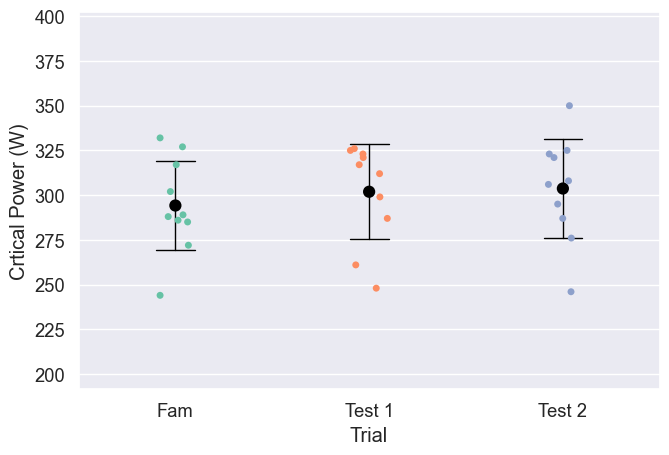

In [3]:
# set graph plot heme, style and size;
sns.set_theme(style="darkgrid", font_scale=1.2)
sns.set_style({'font.family':'sans-serif'})
ax = plt.subplots(figsize=(7.5, 5), dpi=100)

#  set x and y variables - i've taken from assigned variable names
x = df[group_variable]  
y = df[dependent_variable]

#  create graph, provide x and y variables as well as data, 
#  CI set at SD,
#  linestyle set to dash, 
#  join (line between points) set as False ('off')

ax = sns.pointplot(x=x, y=y, data=df, 
                   ci = 'sd', errwidth=1, capsize = 0.2,
                   linestyles=["--"], color = 'black', linewidth = 1.5,
                   join=False)

#  plots all individual plots, data the same as above
sns.stripplot(x=x, y=y, data=df, dodge=True, ax=ax,
              alpha=1, palette = 'Set2')

#  set y axis max and min values for pointplot based on max/min values; 
y_max = y.max()+((y.max()/100)*15)
y_min = y.min()-((y.max()/100)*15)

#  set y limit values, xlabel and ylabel;
ax.set(ylim=(y_min, y_max), 
       xlabel='Trial', 
       ylabel='Crtical Power (W)')

#save as .png file;
plt.savefig('trial_means.png')

plt.show()

In [4]:
#  make sure your data is sorted properly, firstly with subject column, and then trial/group column
#  creates new dataframe
df_diff = df.sort_values(by=[subject_variable, group_variable]).reset_index(drop = True)
#  rename trial/group column to combine trial x and x+1
df_diff[group_variable] = (df_diff.groupby([subject_variable]).cumcount()+1).astype(str)+" - "+ df_diff.groupby([subject_variable]).cumcount().astype(str)

#  only take diffs where next row is of the same group
df_diff['diffs'] = np.where(df_diff[subject_variable] == 
                            df_diff[subject_variable].shift(1), 
                            df_diff[dependent_variable].diff(), 0)

#  remove the top row of each subject grouping, not needed as 'diffs' contains 0 and trial is 1-0. 
df_diff = df_diff.groupby(subject_variable).apply(lambda group: group.iloc[1:, 1:]).reset_index(drop = True)

df_diff.head()

,trial,power,diffs
0,2 - 1,248,-24.0
1,3 - 2,246,-2.0
2,2 - 1,299,14.0
3,3 - 2,295,-4.0
4,2 - 1,312,23.0


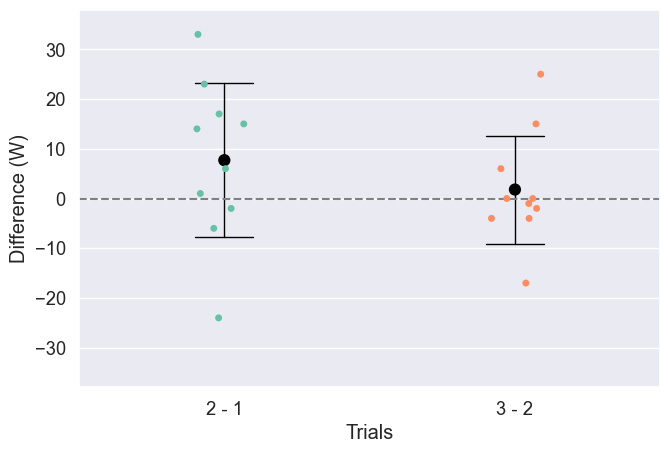

In [5]:
#  set figure size
ax = plt.subplots(figsize=(7.5, 5), dpi=100)

#  select x,y variables. y picked from 
x = df_diff[group_variable]
y = df_diff['diffs']

#  plot pointplot again, 
ax = sns.pointplot(x=x, y=y, data=df_diff, 
                   ci = 'sd', errwidth=1, capsize = 0.2,
                   linestyles=["--"], color = 'black', linewidth = 1.5,
                     join=False)

#  plot indiviual data points again;
sns.stripplot(x=x, y=y, data=df_diff, dodge=True, ax=ax,
              alpha=1, palette = 'Set2')

x_labels = df_diff[group_variable].unique()
#  rename major tick labels
ax.set_xticklabels(x_labels)

#  draw line at 0  
ax.axhline(0, color='gray', linestyle='--')

#  set limits - i've gone for a +- y axis
y_max = y.max()+((y.max()/100)*15)
y_min = -abs(y_max) #  turn y_max into negative number to put on axis

ax.set(ylim=(y_min, y_max), 
             xlabel='Trials', 
             ylabel='Difference (W)')

plt.savefig('trial_differences.png')
plt.show()

In [6]:
#  assumption testing - normality
normality = pg.normality(data=df, dv = dependent_variable, group = group_variable).round(3)
normality

,W,pval,normal
Fam,0.950,0.664,True
Test 1,0.827,0.031,False
Test 2,0.972,0.912,True


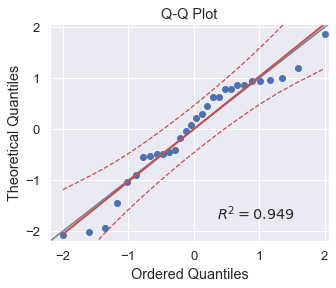

In [7]:
# assign variable to be then represented in Q-Q plots;
q_variable = df[dependent_variable]

#  Q-Q Plots for inspection; 
x = df['power']
ax = pg.qqplot(q_variable, dist='norm')
ax.set(xlabel='Ordered Quantiles', ylabel='Theoretical Quantiles')
plt.savefig('qq_plot.png')
plt.show()

In [8]:
#  run one-way repeated measures ANOVA
#  'correction' will shoe GG correction factor and also highlight if sphericity has been met...
#  ('True/False') then W-spher and p-sher values;
anova = pg.rm_anova(data = df,
                  dv = dependent_variable, within = group_variable, subject = subject_variable, 
                  detailed = True, correction = True).round(3)
anova

,Source,SS,DF,MS,F,p-unc,p-GG-corr,np2,eps,sphericity,W-spher,p-spher
0,trial,509.267,2,254.633,1.949,0.171,0.184,0.178,0.757,True,0.679,0.212
1,Error,2352.067,18,130.670,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
# run post-hoc analysis, i've chosen to run bonferroni post-hoc analysis
post_hoc = pg.pairwise_ttests(data = df,
                              dv = dependent_variable, within = group_variable, subject = subject_variable, 
                              padjust = 'bonf').round(3)
post_hoc

,Contrast,A,B,Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,hedges
0,trial,Fam,Test 1,True,True,-1.495,9.0,two-sided,0.169,0.508,bonf,0.73,-0.271
1,trial,Fam,Test 2,True,True,-1.526,9.0,two-sided,0.161,0.484,bonf,0.754,-0.326
2,trial,Test 1,Test 2,True,True,-0.497,9.0,two-sided,0.631,1.000,bonf,0.343,-0.060


In [10]:
#  create list to insert dictionary keys and append
measurement_properties_list = []

#  get a list of unique trial names to use in for loop
group_unique = df[group_variable].unique()

#  create function for effect_size bands;
def es_bands(es):
    if es <0.2:
        return 'trivial'
    elif es >=0.2 and es <0.6:
        return 'small'
    elif es >=0.6 and es <1.2:
        return 'moderate'
    elif es >=1.2:
        return 'large'

    
#  for loop to iterate through and collate measurement properties for each trial pairing (i.e. trial 2-1);        
for group, group2 in zip(group_unique, group_unique[1:]):
    #  select data ready for analysis;
    x_df = df[df[group_variable].str.contains(group)]    # select first trial group
    y_df = df[df[group_variable].str.contains(group2)]   # select second tral group
    x = x_df[dependent_variable].to_numpy()   # convert to an array
    y = y_df[dependent_variable].to_numpy()
    
    #  calculate effect size;
    effect_size = abs(round(pg.compute_effsize(x, y, paired=False, eftype='hedges'),2))   # hedges g for smaller sample sizes
    
    #  calculate difference between trials for individuals  
    individual_trial_differences = y-x   
    change_in_the_mean = individual_trial_differences.mean()   # mean difference for trials 
    #  calculate mean for trials x,y
    trial_xy_mean = (y.mean()+x.mean())/2   # trial x,y means (used to then convert absolute measures into relative)
    
    #  calculate typicak error - std(differences between trial x,y)/sqrt(2); 
    typical_error = np.std(individual_trial_differences, ddof=1)/np.sqrt(2)
    
    #  calculate coefficient of variation using trial means
    cofv = (typical_error/trial_xy_mean)*100
    
    #  calculate minimal detectable change - (technical error*1.96)*sqrt(2)
    mdc = (typical_error*1.96)*np.sqrt(2)
    
    #  calculate smallest worthwhile change - (sd of individual trial means *0.2)
    individual_trial_mean = (x+y)/2   # individual trial means (participant 1 x,y mean)
    trial_stdev = np.std(individual_trial_mean)   # stdev for the individual trial means
    swc = trial_stdev*0.2
    
    #  create dictionary of measurement properties and then append to list. convert to dataframe and export to excel file; 
    measurement_properties_dictionary = {
        'trial' : f'Trials {group2} - {group}',
        'mean_ratio': round(x.mean()/y.mean(),2),
        'change_in_the_mean': change_in_the_mean,
        'effect_size': effect_size,
        'es_interpretation': es_bands(effect_size),
        'typical_error': typical_error,
        'cofv_%': cofv,
        'mdc_abs': mdc,
        'mdc_%': (mdc/trial_xy_mean)*100,
        'swc_abs': swc,
        'swc_%': (swc/trial_xy_mean)*100,  
    }
    measurement_properties_list.append(measurement_properties_dictionary)
    
    print("Trials: ",group2,"-",group)
    print('Effect Size = ',effect_size, f'({es_bands(effect_size)})')   # use function created above to add interpretation to effect size
    print('Typical Error = ', round(typical_error,1))
    print('Coefficient of Variation =', f'{round(cofv,1)}%')
    print('---')

reliability_summary = pd.DataFrame(measurement_properties_list).round(3)

Trials:  Test 1 - Fam
Effect Size =  0.27 (small)
Typical Error =  11.5
Coefficient of Variation = 3.9%
---
Trials:  Test 2 - Test 1
Effect Size =  0.06 (trivial)
Typical Error =  8.1
Coefficient of Variation = 2.7%
---


In [12]:
#  create empty list to input each ICC output
icc_list = []

for group, group2 in zip(group_unique, group_unique[1:]):   # get the trial and trial +1 to be able to loop through as a pair
    icc_df = df[df[group_variable].str.contains(f'{group}|{group2}')]   # select only two groups in dataframe to then be analysed in ICC analysis
    icc = pg.intraclass_corr(data=icc_df, targets=subject_variable, raters=group_variable,
                         ratings=dependent_variable).round(3)
    icc = icc.iloc[[2]] 
    icc['trial'] = f'{group2} - {group}'
    icc_list.append(icc)   # append the icc output to a list
    appended_icc_list = pd.concat(icc_list)
    print(icc)
    
icc_df = pd.DataFrame(appended_icc_list)   # convert icc_list into dataframe

   Type          Description    ICC       F  df1  df2   pval         CI95%  \
2  ICC3  Single fixed raters  0.821  10.204    9    9  0.001  [0.43, 0.95]   

          trial  
2  Test 1 - Fam  
   Type          Description   ICC       F  df1  df2  pval         CI95%  \
2  ICC3  Single fixed raters  0.92  24.105    9    9   0.0  [0.71, 0.98]   

             trial  
2  Test 2 - Test 1  


In [28]:
#  create a single excel sheet containing all the relevant data;
    #  normality
    #  anova & post hoc analysis
    #  summary of reliability measurement properties
    #  icc's

with pd.ExcelWriter('notebook_output.xlsx') as writer:  
    normality.to_excel(writer, sheet_name='normality_output')
    anova.to_excel(writer, sheet_name='anova_output')
    post_hoc.to_excel(writer, sheet_name='post_hoc_output')
    reliability_summary.to_excel(writer, sheet_name='reliability_output')
    icc_df.to_excel(writer, sheet_name='icc_output')